In [1]:
import ertai
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
assert ertai.__version__ == "0.0.2"

In [3]:
spell_cost = ertai.Mana("Blue", "Blue")
spell_cost

2 Blue Mana

In [6]:
mana_pool = ertai.Mana("Black", "Red", "Blue", "Red")
mana_pool

1 Black Mana, 2 Red Mana, 1 Blue Mana

In [7]:
spell_cost <= mana_pool

False

# Mana curve

In [8]:
def create_deck(n, L):
    """
    Given a vector n and a number of lands L build a deck.
    """
    number_of_lands = L
    deck = [ertai.BasicLand() for _ in range(number_of_lands)]
    
    for cost, number in enumerate(n):
        cost = ertai.Mana(*(None for _ in range(cost)))
        deck += [ertai.Card(cost=cost) for _ in range(number)]
    return deck

In [9]:
def play_most_expensive_cards(hand, pool):
    """
    Given a mana pool and a hand.
    
    Play as many cards as possible (playing most expensive ones first)
    
    Return number of cards cast, the played card and the remaining pool
    after all possible cards are played.
    """
    sorted_hand = sorted(hand, reverse=True, key=lambda card: sum(card.cost.counter.values()))
    
    played = []
    number_cast = 0
    for card in sorted_hand:
        if (card.cost <= pool) and isinstance(card, ertai.BasicLand) is False:
            pool = card.cast(pool)
            hand.remove(card)
            played.append(card)
            number_cast += 1
    return number_cast, played, pool

In [10]:
def play_land(hand):
    """
    Given a hand if there is a land in the hand it will play it.
    """
    for card in hand:
        if isinstance(card, ertai.BasicLand):
            hand.remove(card)
            return card
    return None

In [11]:
def play(n, L, seed=0, play_until=0):
    """
    This will play a return:
    
    - the number of cards player in each turn
    - the cost of cards played in each turn
    - total number of mana available in each turn
    """
    deck = create_deck(n=n, L=L)
    random.seed(seed)
    random.shuffle(deck)
    
    hand, deck = deck[:7], deck[7:]
    lands = []
    number_of_cards_played = []
    number_of_mana_available = []
    cost_of_played_cards = []
    
    while (deck_length := len(deck)) > play_until:

        hand.append(deck.pop())

        if (land := play_land(hand)) is not None:
            lands.append(land)

        pool = ertai.Mana()
        for land in lands:
            land.untap()
            pool += land.generate_mana()
        
        number, cards, pool, = play_most_expensive_cards(hand=hand, pool=pool)
        
        while(len(hand)) > 7:
            random.shuffle(hand)
            hand.pop()
        
        number_of_cards_played.append(number)
        cost_of_played_cards.append(sum(sum(card.cost.counter.values()) for card in cards))
        number_of_mana_available.append(len(lands))
        
    return number_of_cards_played, cost_of_played_cards, number_of_mana_available

Let us get some data!

In [12]:
deck_configurations = (
    (0, 8, 10, 6, 2, 2, 4, 4),  # my current deck
    (0, 4, 14, 6, 2, 2, 4, 4),  # remove 4 ascendant spirits and play 2 more Negate + Rejects
    (0, 6, 10, 6, 2, 2, 4, 6),  # playing more Alrund's Epiphany's, removing 2 stern dissmissal's
    (0, 8, 8, 6, 2, 2, 4, 6),  # playing more Alrund's Epiphany's, removing 2 rejects
    (0, 0, 0, 10, 10, 10, 5, 5),
)

In [13]:
mana_ratios = [[] for _ in deck_configurations]
for ratio, n in zip(mana_ratios, deck_configurations):
    for seed in range(1_000):
        L = 60 - np.sum(n)
        number_of_cards_played, cost_of_played_cards, number_of_mana_available = play(n, L, seed=seed, play_until=0)
        ratio.append(np.array(cost_of_played_cards) / np.array(number_of_mana_available))

<ipython-input-13-e14efb1664f1>:6: RuntimeWarning: invalid value encountered in true_divide
  ratio.append(np.array(cost_of_played_cards) / np.array(number_of_mana_available))


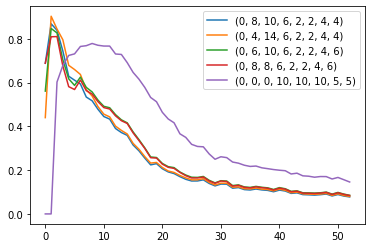

In [14]:
plt.figure()
for ratio, n in zip(mana_ratios, deck_configurations):
    plt.plot(np.nanmean(ratio, axis=0), label=str(n))
plt.legend();